<a href="https://colab.research.google.com/github/roulupen-mldl/EVA7/blob/main/IntroToPytorch_Session2_5/Session_2_5_PyTorch_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement:
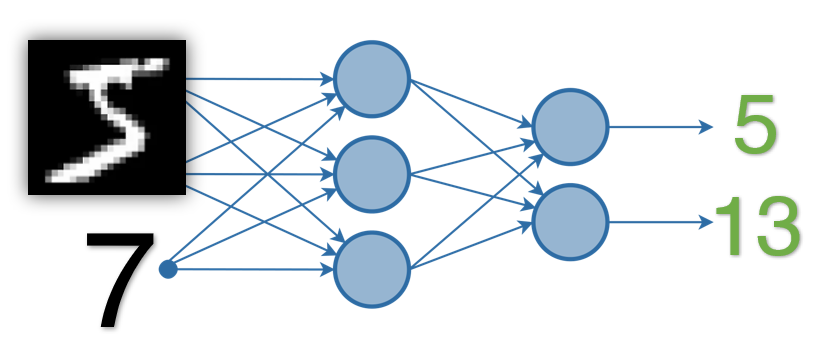

1. Write a neural network that can:
  1. Inputs:
    1. an image from the MNIST dataset (say 5), and
    2. a random number between 0 and 9, (say 7)
  2. Outputs:
    1. the "number" that was represented by the MNIST image (predict 5), and
    2. the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor
from torchsummary import summary

import matplotlib.pyplot as plt

## Data Preparation:
- Since we need to provide 2 inputs to the model and one of them is a random number so we need to create a custom data set and the data set should provide two inputs and one output where the output will contain both prediction of input number from MNIST and the sum of the numbers.

In [2]:
class CustomMNIST(Dataset):
  def __init__(self, mnist_data):
    self.mnist = mnist_data

    # converts the mnist data to float32
    self.mnist.data = self.mnist.data.float()

    # generates random number 
    random_num = torch.randint(0, 9, (len(mnist_data),) )

    # creating one hot encoding for the random number
    self.random_num_one_hot = F.one_hot(random_num, num_classes=10)

    # adding random number with the mnist target
    sum_output = random_num + self.mnist.targets

    # concatenates the MNIST target and the sum, so that while model evaluation we can check the generated output with different tenror range
    # Example: Output shape[batch_size x 29], targets[batch_size x 29]
    # Here 29 comes from, First 10 for predicting the MNIST number(0-9) and next 19 is sum of the numbers(0-18)
    self.targets = torch.cat((torch.reshape(self.mnist.targets, (len(mnist_data), 1)), torch.reshape(sum_output, (len(mnist_data), 1))), 1)

  def __getitem__(self, index):
    # In get item we are returning image, input number and expected target
    return (torch.reshape(self.mnist.data[index], (1, 28, 28)), self.random_num_one_hot[index].float(), self.targets[index])

  def __len__(self):
    return len(self.mnist)


In [3]:
# Loading train data
mnist_train_set = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

# Loading test data
mnist_test_set = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform = transforms.ToTensor()
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# Preparing custom dataset from MNIST images
custom_mnist_train = CustomMNIST(mnist_train_set)
custom_mnist_test = CustomMNIST(mnist_test_set)

print(len(custom_mnist_train), len(custom_mnist_test))

60000 10000


In [5]:
# Generating train and test loader from the custom dataset
torch.manual_seed(1)
batch_size = 128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(custom_mnist_train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(custom_mnist_test, batch_size=batch_size, shuffle=True, **kwargs)

In [6]:
# checking few train loader data sizes
data=iter(train_loader)
images, random_nums, output = next(data)
print(f"number of samples{images.shape} {images.dtype}")
print(f"number of labels {random_nums.shape} {random_nums.dtype}")
print(f"Outout {output.shape} {output.dtype}")

number of samplestorch.Size([128, 1, 28, 28]) torch.float32
number of labels torch.Size([128, 10]) torch.float32
Outout torch.Size([128, 2]) torch.int64


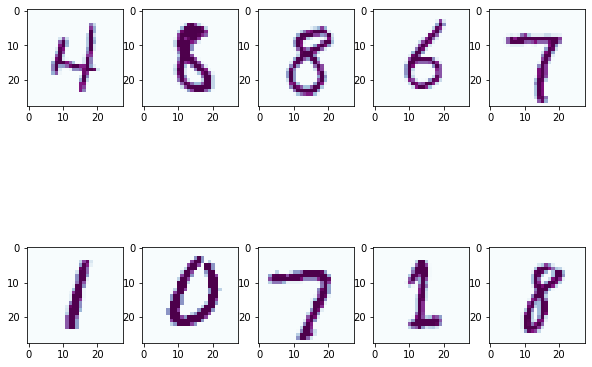

In [7]:
# displaying few sample images
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0], cmap='BuPu')
plt.show()

## Model

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) # 1x28x28 | 32x(1 x 3 x 3)(padding=1) | 32 x 28 x 28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # 32x28x28 | 64x(1 x 3 x 3)(padding=1) | 64 x 28 x 28
        self.pool1 = nn.MaxPool2d(2, 2) # 64x28x28 | MP | 64 x 14 x 14
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # 64x14x14 | 128x(1 x 3 x 3)(padding=1) | 128 x 14 x 14
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # 128x14x14 | 256x(1 x 3 x 3)(padding=1) | 256 x 14 x 14
        self.pool2 = nn.MaxPool2d(2, 2) # 256x14x14 | MP | 256 x 7 x 7
        self.conv5 = nn.Conv2d(256, 512, 3) # 256x7x7 | 512x(1 x 3 x 3) | 512 x 5 x 5
        self.conv6 = nn.Conv2d(512, 1024, 3) # 512x5x5 | 1024x(1 x 3 x 3) | 1024 x 3 x 3
        
        # First fully connected layer
        self.fc1 = nn.Linear(9216, 128) # 1024 * 3 * 3 = 9216 | 128

        # Fully connected layer for sum number
        self.fcsum = nn.Linear(10, 20) #SUM Input: 10 | 20
        
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(148, 29) # 128 + 20 = 148 | 29 (targets)

    def forward(self, x, num):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) # 1 x 28 x 28 | 64 x 14 x 14, RF = 8 x 8
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x))))) # 64 x 14 x 14 | 256 x 7 x 7 , RF = 24 x 14
        x = F.relu(self.conv6(F.relu(self.conv5(x)))) # 256 x 7 x 7 | 1024 x 3 x 3, RF = 28 x 28

        x = torch.flatten(x, 1) # Flattens to 1D tensor
        num = torch.flatten(num, 1) # Flattens to 2D tensor

        # Pass data through fc1
        x = F.relu(self.fc1(x)) # Fully connected layer

        # First FC layer for random number
        num = F.relu(self.fcsum(num))

        # Concatenating X FC to num FC
        x = torch.cat((x, num), 1)

        # Pass data through fc2
        x = F.relu(self.fc2(x))

        x = x.view(-1, 29)
        return F.log_softmax(x, dim=1) # applying softmax activation for final classification

**Displaying Model Summary**

In [9]:
model = Net().to(device)
summary(model, input_size=[(1, 28, 28), (1, 1, 10)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Linear-9                  [-1, 128]       1,179,776
           Linear-10                   [-1, 20]             220
           Linear-11                   [-1, 29]           4,321
Total params: 7,471,933
Trainable params: 7,471,933
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forw

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


**Functions to train and analyze the model output**

In [10]:
from tqdm import tqdm

# Find out number of correct predictions and number of wrong prediction
def get_num_correct(preds, labels):
   return preds.argmax(dim=1).eq(labels).sum().item()

# train the model for an epoch
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    # Initialize tqdm library to track the training progress
    pbar = tqdm(train_loader)

    total_correct_img = 0
    total_correct_sum = 0

    # iterate over different batches to train the model
    for batch_idx, (data, input_num, target) in enumerate(pbar):

      # Sending the tensors to the GPU/CPU
      data, input_num, target = data.to(device), input_num.to(device), target.to(target)

      # Setting zero grad to avoid grdient explosion
      optimizer.zero_grad()

      # Actual model call
      output = model(data, input_num)

      # As we value to predict the image and also the sum, so we need to split the result into two parts
      # Similary we need to split the actual target to two parts
      output1, output2 = torch.tensor_split(output, (10,), dim=1)
      target1, target2 = torch.tensor_split(target, (1,), dim=1)

      target1 = torch.squeeze(target1).to(device)
      target2 = torch.squeeze(target2).to(device)

      # Loss for image prediction
      loss1 = F.cross_entropy(output1, target1)

      # Loss for sum
      loss2 = F.cross_entropy(output2, target2)

      # combining loss
      loss = loss1 + loss2

      # backpropagation of loss
      loss.backward()
      optimizer.step()

      # Calculate total correct prediction for images and sum
      total_correct_img += get_num_correct(output1, target1)
      total_correct_sum += get_num_correct(output2, target2)
      
      pbar.set_description(desc= f'loss1={loss1.item()} loss2={loss2.item()} total_correct_img={total_correct_img} total_correct_sum={total_correct_sum}  batch_id={batch_idx}')


In [11]:
# Initializing the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Running over the epoch
for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, epoch)

loss1=0.4176105558872223 loss2=2.585218667984009 total_correct_img=46894 total_correct_sum=6995  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s]
loss1=0.13872717320919037 loss2=2.384842872619629 total_correct_img=53426 total_correct_sum=10218  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.38it/s]
loss1=0.3455824851989746 loss2=2.3231139183044434 total_correct_img=53621 total_correct_sum=15648  batch_id=468: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]
loss1=0.3852669894695282 loss2=2.3504421710968018 total_correct_img=53694 total_correct_sum=19005  batch_id=468: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s]
loss1=0.14558863639831543 loss2=2.0326640605926514 total_correct_img=53767 total_correct_sum=20970  batch_id=468: 100%|██████████| 469/469 [00:35<00:00, 13.33it/s]
loss1=0.07290605455636978 loss2=2.232471227645874 total_correct_img=53799 total_correct_sum=22407  batch_id=468: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s]
loss1=0.264628678560256